# Non-Markovianity

## data

In [2]:
import qsvm.Qmapping as Q
import qsvm.data_function as df
import numpy as np
import matplotlib.pyplot as plt

In [6]:
f = open('./Datasets/standard_quantum.json', 'r') 
tg = json.load(f)
f.close()
x_train_lst = tg['train']['data']
x_test_lst = tg['test']['data']
y_train = tg['train']['label']
y_test = tg['test']['label']

In [7]:
interval=np.linspace(0,0.06,7)

In [8]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in y_train:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [9]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

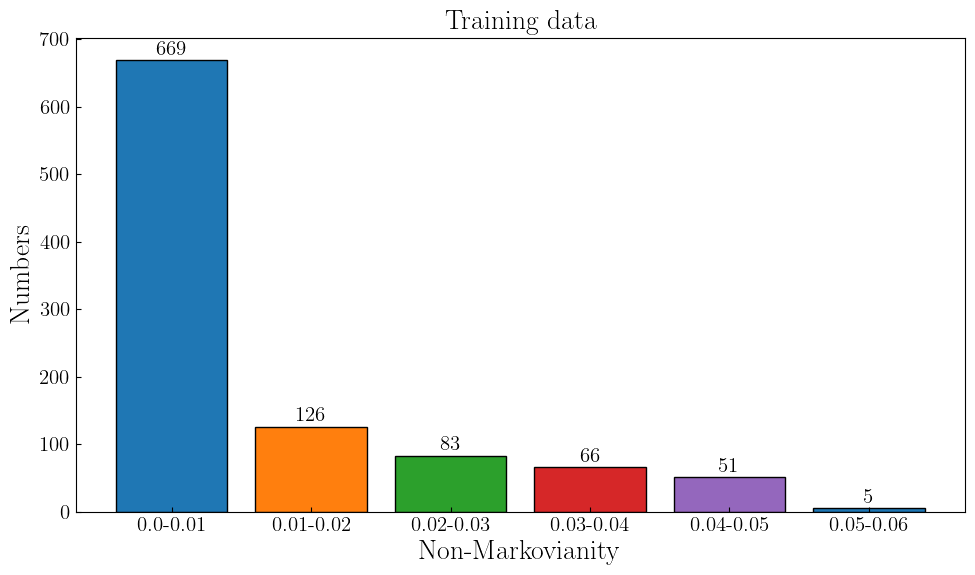

In [10]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Training data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

In [11]:
interval=np.linspace(0,0.06,7)

In [12]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in y_test:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [13]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

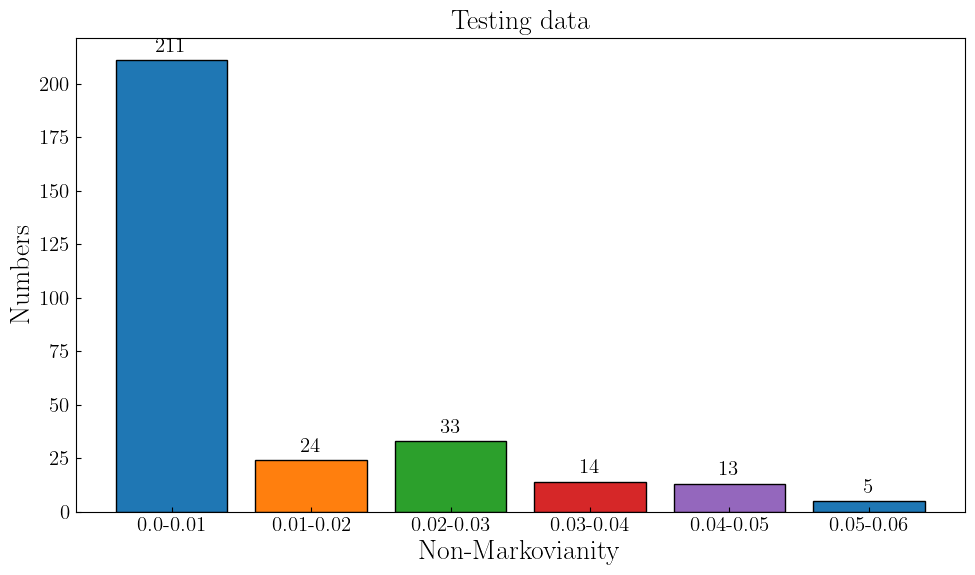

In [14]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Testing data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

## Data pre-processing

In [15]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


### PCA

In [16]:

#step1
scaler = StandardScaler()
train = scaler.fit_transform(x_train_lst)
test = scaler.fit_transform(x_test_lst)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 10 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
x_train_lst = np.real(np.dot(train, eig_vec))
x_test_lst = np.real(np.dot(test, eig_vec))
x_train_lst=np.array(x_train_lst)
x_test_lst=np.array(x_test_lst)

### Renormalize each feature

In [17]:
# def scaler(x_train_lst,)

f_scale =[]
f_min =[]

Norm=np.pi/2
for i in range(0 ,len(x_train_lst[0])) :
  tg = [x[i] for x in x_train_lst]
  f_scale.append(np.max(tg) - np.min(tg))
  f_min.append(np.min(tg))
trs_tr = []
for x in x_train_lst :
  rs = []
  for i , scale , min in zip(x ,f_scale , f_min) :
    rs.append((i-min)/scale*Norm)
  trs_tr.append(rs)
trs_t = []
for x in x_test_lst :
  rs = []
  for i , scale , min in zip(x ,f_scale , f_min) :
    rs.append((i-min)/scale*Norm)
  trs_t.append(rs)

x_train_lst = trs_tr
x_test_lst = trs_t
train_pca_q=trs_tr
test_pca_q=trs_t

x_train_lst=np.array(x_train_lst)
x_test_lst=np.array(x_test_lst)

## Construct Quantum Kernal

In [18]:
import time

In [19]:
C6 = 5.42e-24
desire_rabi = 8*np.pi *1e6
R0=(C6/desire_rabi)**(1/6)
a=R0*1.2
raby = 1
pos = [i * a for i in range(10)]
# npos = noisy_pos (pos,error)
# config = get_config(npos)
# show_kmatrix(train = config , test = config,name = "")


In [20]:
R0

7.743903001897659e-06

In [21]:
dim=10
operator_list = [[] for i in range(dim)]
matrix = np.ones([dim ,dim])
for idx ,x in enumerate(matrix) :
    for idy ,y in enumerate(x) :
        operator_list[idx].append(Q.form_op([idx , idy] ,Q.rr ,10))

In [22]:
# from tqdm.notebook import trange, tqdm
op ="x"
tier=2
mode="quera"
t=np.pi
# error=[0.005,0.01,0.1]
error=None
start = time.time()
qx_train_lst = Q.Qmap(pos , dim ,t ,train_pca_q, raby,op,operator_list,tier, mode,error=error)
qx_test_lst = Q.Qmap(pos , dim ,t ,test_pca_q, raby,op,operator_list,tier, mode,error=error)
end=time.time()

In [23]:
cost_time=end-start

In [47]:
i=0
target_kernel = Q.get_q_kernel(qx_train_lst[i],qx_train_lst[i])

In [48]:
test_kernel = Q.get_q_kernel(qx_test_lst[i],qx_train_lst[i] , status = "test")

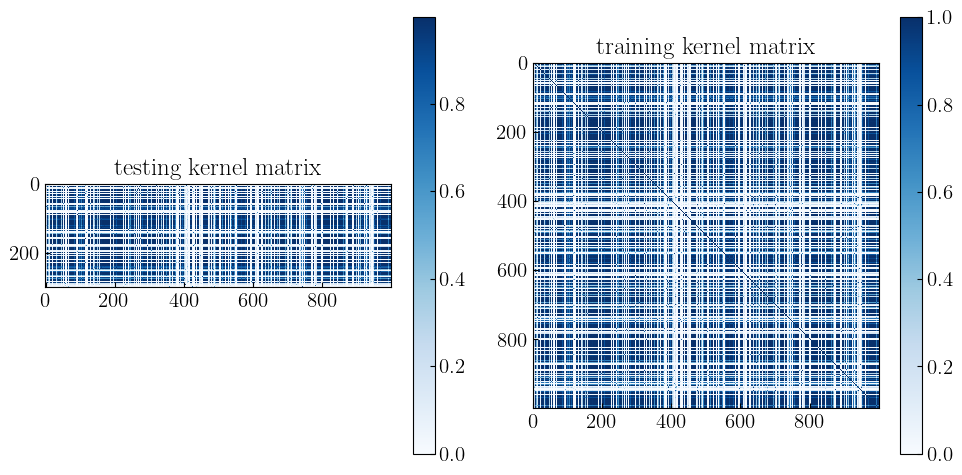

In [49]:
Q.show_kmatrix(train = target_kernel , test = test_kernel,name = "")

## Supported Vector Machine

### Quantum kernel

In [50]:
from sklearn.svm import SVR
import sklearn

In [51]:
svr = SVR()
argv = df._tune(svr,np.array(target_kernel) , y_train ,np.array(test_kernel) , y_test, ['precomputed'] , tg = 'ts' )
argv

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


{'kernel': 'precomputed', 'epsilon': 0.0, 'C': 0.5}

In [52]:
svr = SVR(kernel = argv['kernel'] , epsilon = argv['epsilon'] , C = argv['C'])
#svr = SVR(kernel = 'precomputed' , epsilon = 0)
svr.fit(target_kernel, y_train)

SVR(C=0.5, epsilon=0.0, kernel='precomputed')

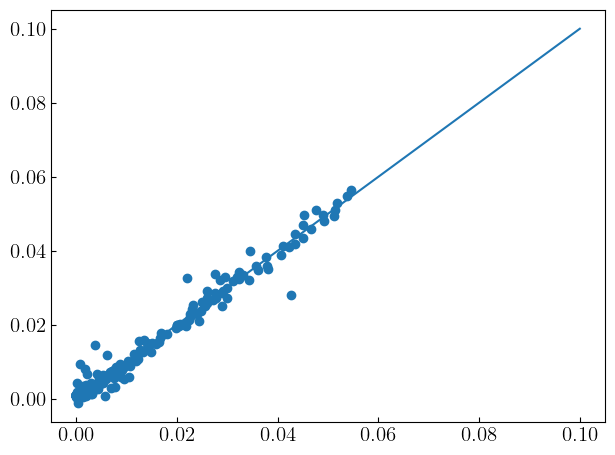

In [53]:
rs_t = svr.predict(test_kernel)
df._plot(y_test , rs_t , 99 , name = '')

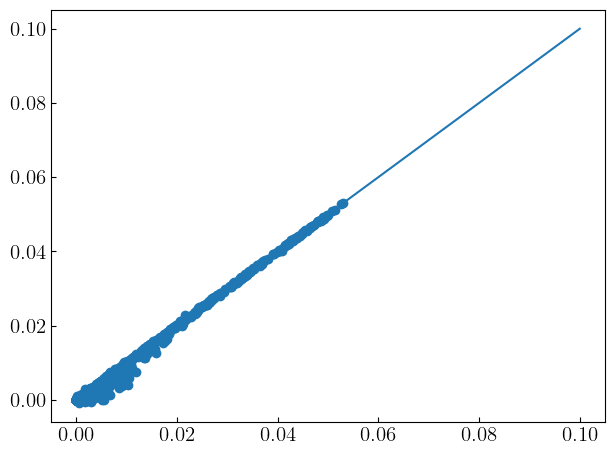

In [54]:
rs = svr.predict(target_kernel)
df._plot(y_train , rs ,99 , name = '')

### linear

In [55]:

x_train_lst=np.array(x_train_lst)
x_test_lst=np.array(x_test_lst)

_k = sklearn.metrics.pairwise.linear_kernel(x_train_lst)
_kk = sklearn.metrics.pairwise.linear_kernel(x_test_lst,x_train_lst)

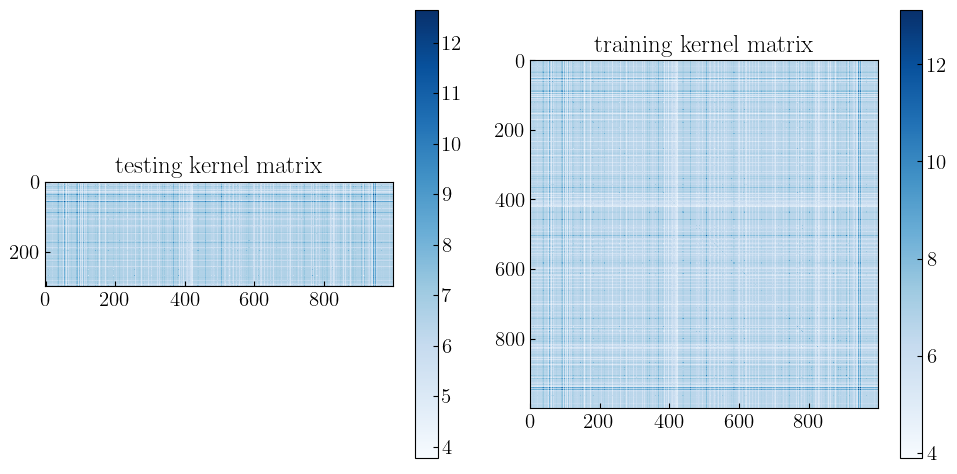

In [56]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [57]:
mth = 'linear'
linear_svr = SVR()
argv = df.tune(linear_svr,x_train_lst , y_train , [mth])
argv

{'kernel': 'linear', 'epsilon': 0.423, 'C': 0.2}

In [58]:
linear_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
linear_svr.fit(x_train_lst, y_train)

SVR(C=0.9, epsilon=0, kernel='linear')

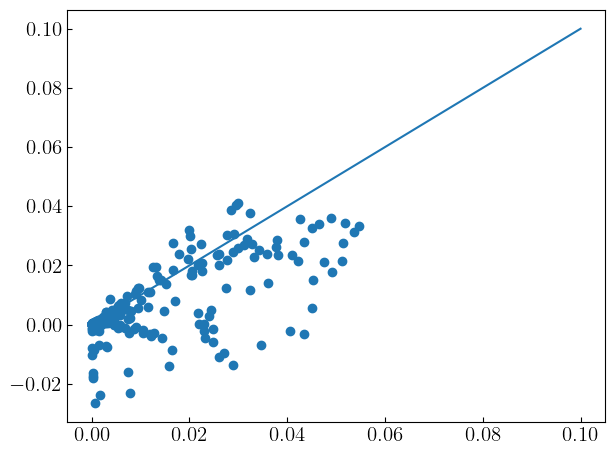

In [59]:
linear_rs_t = linear_svr.predict(x_test_lst)
df._plot(y_test , linear_rs_t , 999 , name = '')

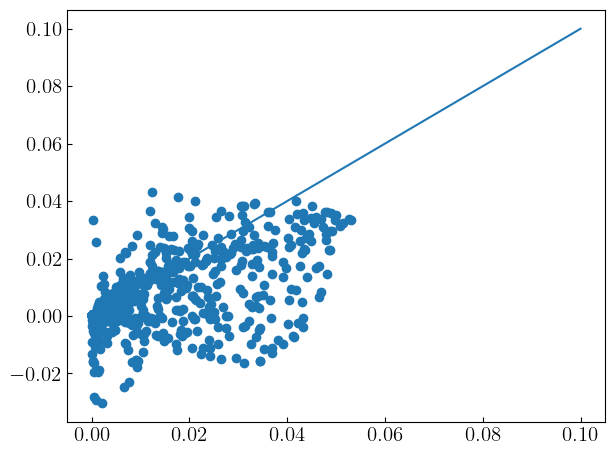

In [60]:
linear_rs = linear_svr.predict(x_train_lst)
df._plot(y_train , linear_rs , 999 , name = '')

### rbf

In [61]:

x_train_lst=np.array(x_train_lst)
x_test_lst=np.array(x_test_lst)

_k = sklearn.metrics.pairwise.rbf_kernel(x_train_lst,gamma=1/(10*x_train_lst.var()))
_kk = sklearn.metrics.pairwise.rbf_kernel(x_test_lst,x_train_lst,gamma=1/(10*x_train_lst.var()))

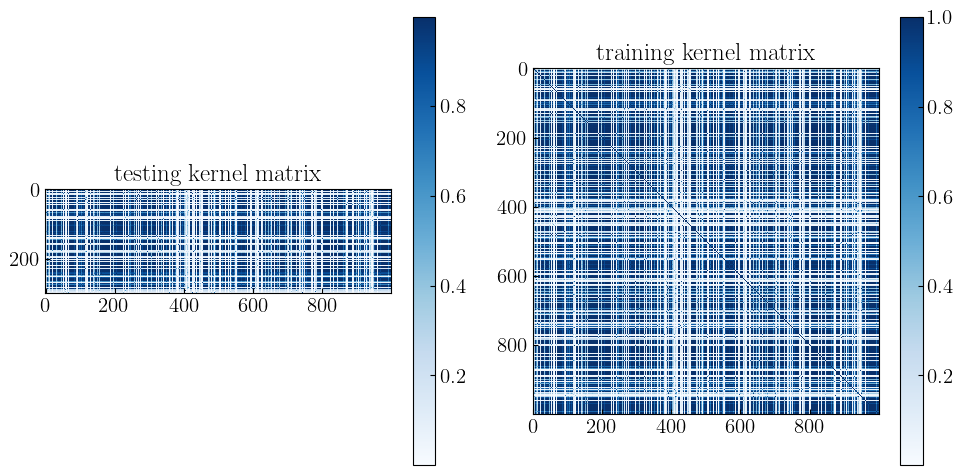

In [62]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [63]:
mth = 'rbf'
_svr = SVR()
argv = df.tune(_svr,x_train_lst , y_train , [mth])
argv

{'kernel': 'rbf', 'epsilon': 0.305, 'C': 0.7000000000000001}

In [64]:
_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
_svr.fit(x_train_lst, y_train)

SVR(C=0.9, epsilon=0)

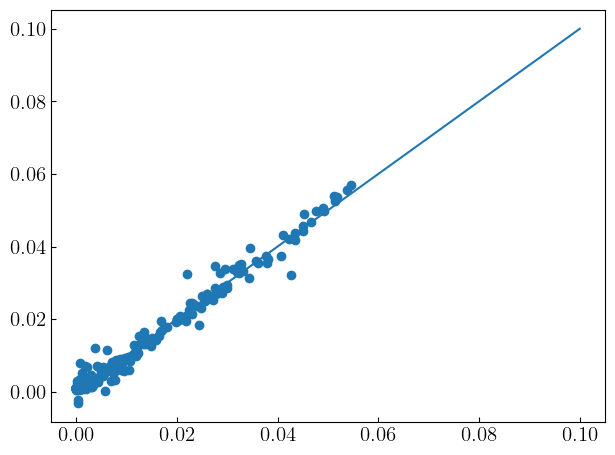

In [65]:
_rs_t = _svr.predict(x_test_lst)
df._plot(y_test , _rs_t , 999 , name = '')

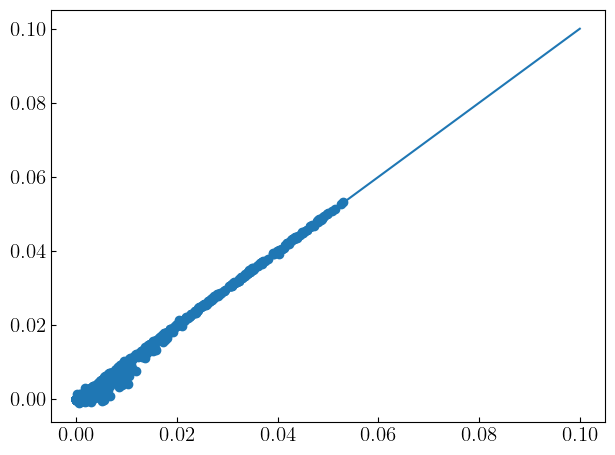

In [66]:
_rs = _svr.predict(x_train_lst)
df._plot(y_train , _rs , 999 , name = '')

## Result

In [67]:
print(f'Classical linear testing mse : {mse(linear_rs_t , y_test)}')
print(f'Classical rbf testing mse : {mse(_rs_t , y_test)}')
print(f'Quantum testing mse : {mse(rs_t,y_test)}')

Classical linear testing mse : 0.00011697990293373701
Classical rbf testing mse : 3.6556318895643892e-06
Quantum testing mse : 3.984600485567875e-06


In [68]:
print(f'Classical linear training mse : {mse(linear_rs , y_train)}')
print(f'Classical rbf training mse : {mse(_rs , y_train)}')
print(f'Quantum training mse : {mse(rs,y_train)}')

Classical linear training mse : 0.00014642367631358797
Classical rbf training mse : 6.955754729169039e-07
Quantum training mse : 6.605523192203279e-07
